In [1]:
import numpy as np
import matplotlib.pyplot as plt
import drjit as dr
import mitsuba as mi
mi.set_variant('cuda_acoustic', 'llvm_acoustic', 'cuda_ad_acoustic', 'llvm_ad_acoustic')
from mitsuba import ScalarTransform4f as tf

print(f'{mi.variant() = }')

mi.variant() = 'cuda_acoustic'


In this notebook we will render the energy time curve of a shoebox scene. 

## Room dimensions and material properties

In [27]:
room_dim       = np.array([10, 6, 4]) # Length, Width, Height
receiver_pos   = np.array([2, 2, 1.1])
emitter_pos    = np.array([7, 4, 1.2])
emitter_radius = 0.5

The spectral 

In [28]:
reflectance_top     = [(125, 0.9), (250, 0.3), (500, 0.5), (1000, 0.9)]
reflectance_bottom  = [(125, 0.9), (250, 0.3), (500, 0.5), (1000, 0.5)]
reflectance_left    = [(125, 0.3), (250, 0.5), (500, 0.9), (1000, 0.4)]
reflectance_right   = [(125, 0.3), (250, 0.5), (500, 0.9), (1000, 0.3)]
reflectance_front   = [(125, 0.5), (250, 0.9), (500, 0.3), (1000, 0.2)]
reflectance_back    = [(125, 0.5), (250, 0.9), (500, 0.3), (1000, 0.1)]

scattering_top     = 0.8
scattering_bottom  = 0.9
scattering_left    = 0.4
scattering_right   = 0.8
scattering_front   = 0.3
scattering_back    = 0.6

frequencies = [125, 250, 500, 1000]  # Frequency bins in Hz

## Set Up Scene

Now, we will build a shoebox scene from scratch using basic rectangle shapes.

We set up a spherical emitter with uniform radiance, define the BSDFs of the walls and then set up the scene geometry.

To build the scene geometry, we first build a cube with sidelengths of 1 m with one of the corners placed in the world origin, and then scale the cube to the desired room dimensions.

In [29]:
# Define a scene dictionary with a spherical emitter:
scene_dict = {
    'type': 'scene',

    'emitter': {
        'type': 'sphere',
        'radius': 0.1,
        'center': emitter_pos,
        'emitter': {
            'type': 'area',
            'radiance': {
                'type': 'uniform',
                'value': 50,
            }
        },
    },
}

# Add BSDFs for each surface:
surfaces = ['top', 'bottom', 'left', 'right', 'front', 'back']
scattering_values = [scattering_top, scattering_bottom,
                     scattering_left, scattering_right,
                     scattering_front, scattering_back]
reflectance_values = [reflectance_top, reflectance_bottom,
                      reflectance_left, reflectance_right,
                      reflectance_front, reflectance_back]

for surface, scattering, reflectance in zip(surfaces, scattering_values, reflectance_values):
    # Here we use a blendbsdf to build a specular + diffuse reflection model.
    scene_dict[f'bsdf_{surface}'] = {
        'type': 'blendbsdf',
        'weight': scattering,
        'bsdf_0': {
            'type': 'conductor',
            'specular_reflectance': {
                'type': 'spectrum',
                'value': reflectance,
            },
        },
        'bsdf_1': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'spectrum',
                'value': reflectance,
            }
        },
    }

# Define the 1 m x 1 m x 1 m cube geometry.
scene_dict['cube'] = {
    'type': 'shapegroup',
    'top': {
        'type': 'rectangle', # Rectangle in XY range [-1, 1] x [-1, 1]
        'bsdf': {'type': 'ref', 'id': 'bsdf_top'},
        'to_world': tf().translate([0, 0, 1]).scale(0.5).translate([1, 1, 0]), # transformations are applied from right to left. First we move the corner to the origin and then scale it to a 1m x 1m rectangle
        'flip_normals': True, # flip normals so the surface points inwards
        },
    'bottom': {
        'type': 'rectangle',
        'bsdf': {'type': 'ref', 'id': 'bsdf_bottom'},
        'to_world': tf().scale(0.5).translate([1, 1, 0.]),
        },
    'left': {
        'type': 'rectangle',
        'bsdf': {'type': 'ref', 'id': 'bsdf_left'},
        'to_world': tf().rotate(axis=[0, -1, 0], angle=90).scale(0.5).translate([1, 1, 0.]),
        'flip_normals': True,
    },
    'right': {
        'type': 'rectangle',
        'bsdf': {'type': 'ref', 'id': 'bsdf_right'},
        'to_world': tf().translate([1, 0, 1]).rotate(axis=[0., 1., 0.], angle=90).scale(0.5).translate([1, 1, 0.]),
        'flip_normals': True,
    },
    'front': {
        'type': 'rectangle',
        'bsdf': {'type': 'ref', 'id': 'bsdf_front'},
        'to_world': tf().rotate(axis=[1, 0, 0], angle=90).scale(0.5).translate([1, 1, 0.]),
        'flip_normals': True,
    },
    'back': {
        'type': 'rectangle',
        'bsdf': {'type': 'ref', 'id': 'bsdf_back'},
        'to_world': tf().translate([0, 1, 0]).rotate(axis=[1., 0., 0.], angle=90).scale(0.5).translate([1, 1, 0.]),
    },
}

# scale the shoebox to the room dimensions
scene_dict['shoebox'] = {
    'type': 'instance',
    'geometry': {'type': 'ref', 'id': 'cube'},
    'to_world': tf().scale(room_dim) # scale the 1m x 1m x 1m box to the room dimensions
}

# load the scene
scene = mi.load_dict(scene_dict)


## Visual Rendering

If we want to, we can visually render the scene using a standard camera and integrator from Mitsuba 3.
Note that we are using frequency spectra for our BSDFs, so Mitsuba's spectrum to RGB transformation does not produce expected results (Mitsuba expects spectra to be in wavelength space, not in frequency space).

Nonetheless, we can define a camera that uses a spectral film, which we can set up to render specific frequencies per channel.
Here, we set up the camera to be placed at the microphone position and point to the emitter.

In [35]:
camera = mi.load_dict({
    'type': 'perspective',
    'to_world': tf().look_at(
        origin=receiver_pos,  # camera position
        target=emitter_pos,  # point camera to the center of the room
        up=[0, 0, 1]
    ),
    'fov': 80,
    'film': {
        'type': 'specfilm',
        'width': 1920,
        'height': 1080,
        'band1_125Hz': {
            'type': 'regular',
            'frequency_min': 125,
            'frequency_max': 126,
            'values': '1, 1'
        },
        'band2_250Hz': {
            'type': 'regular',
            'frequency_min': 250,
            'frequency_max': 251,
            'values': '1, 1'
        },
        'band3_500Hz': {
            'type': 'regular',
            'frequency_min': 500,
            'frequency_max': 501,
            'values': '1, 1'
        },
    }
})

integrator_visual = mi.load_dict({
    'type': 'path'
})

### Render visual scene

By passing the camera and the visual integrator to the `render` function, we can render our scene using those settings. The channels of the output image correspond to the frequency bands that we defined in the film.

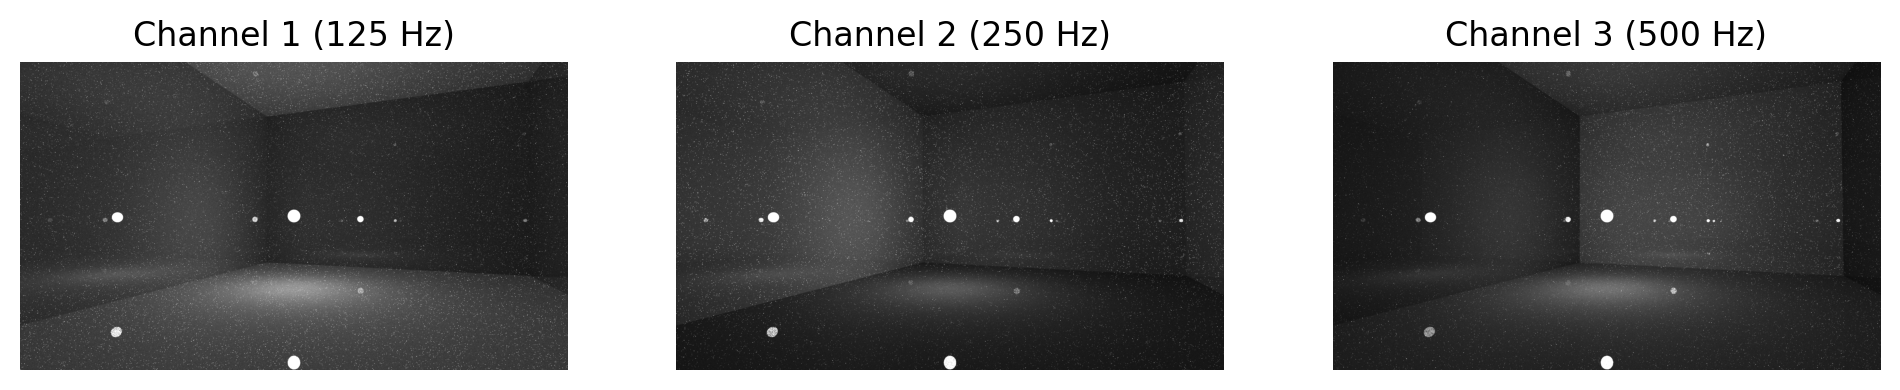

In [37]:
render_visual = True
if render_visual:
    image = mi.render(scene, sensor=camera, integrator=integrator_visual, spp=125)
    n_channels = image.shape[-1]

    fig, ax = plt.subplots(1, n_channels, figsize=(12, 5))
    for i in dr.arange(mi.Int, n_channels):
        ax[i].imshow(mi.util.convert_to_bitmap(image[..., i]))
        ax[i].axis('off')
        ax[i].set_title(f'Channel {i+1} ({frequencies[i]} Hz)')

plt.show()

Here we can observe the typical behavior of the acoustic BSDF model: a strong specular reflection combined with a diffuse reflection. 
Both components are weighted by the reflectance, which is defined as one minus the absorption coefficient.
The scattering coefficient weights the specular and diffuse energy contribution.

## Acoustic Rendering

Rendering the acoustic scene is as easy as replacing the camera with a microphone and the integrator with an acoustic integrator:

In [7]:
max_time = 0.1 # maximum time to simulate in seconds
sampling_rate = 10000 # time bins per second
speed_of_sound = 343 # speed of sound in m/s
time_bins = int(max_time * sampling_rate)

microphone = mi.load_dict({
    'type': 'microphone',
    'origin': receiver_pos,
    'direction': emitter_pos,
    'film': {
        'type': 'tape',
        'frequencies': '125, 250, 500, 1000',  # rendered frequencies
        'time_bins': time_bins,  # number of time bins
    },
})

integrator_acoustic = mi.load_dict({
    'type': 'acoustic_ad',
    'speed_of_sound': speed_of_sound,
    'max_depth': 10,      # stopping criterion for the maximum reflection depth
    'max_time': max_time, # stopping criterion for the maximum propagation time
})


The microphone is an omnidirectional sensor with only one pixel per frequency bin. 
Therefore, the 'samples per pixel' `spp` defines the total number of rays per rendered frequency and we can use a rather high number.

In [38]:
spp = 2**22 
etc = mi.render(scene, sensor=microphone, integrator=integrator_acoustic, spp=spp)

### Plot Energy Time Curve

Now we can plot the resulting Energy Time Curve (ETC):

In [39]:
def plot_etc(etc: mi.TensorXf, sampling_rate, max_time,
             dB = True, normalize = False, bottom=-100):
    """Plot Energy Time Curve"""
    times = np.arange(max_time, step=1/sampling_rate)
    etc = etc.numpy().squeeze()

    plt.xlabel('Time in s')
    plt.ylabel('Amplitude')

    if normalize:
        etc  /= np.max(etc)

    if dB:
        with np.errstate(divide='ignore'):
            etc = 20 * np.nan_to_num(np.log10(np.abs(etc)), neginf=-300)
        plt.ylabel('Amplitude in dB')

    plt.plot(times, etc)
    plt.xlim(0, max_time)
    plt.ylim(bottom=bottom, top=np.max(etc) + 10)

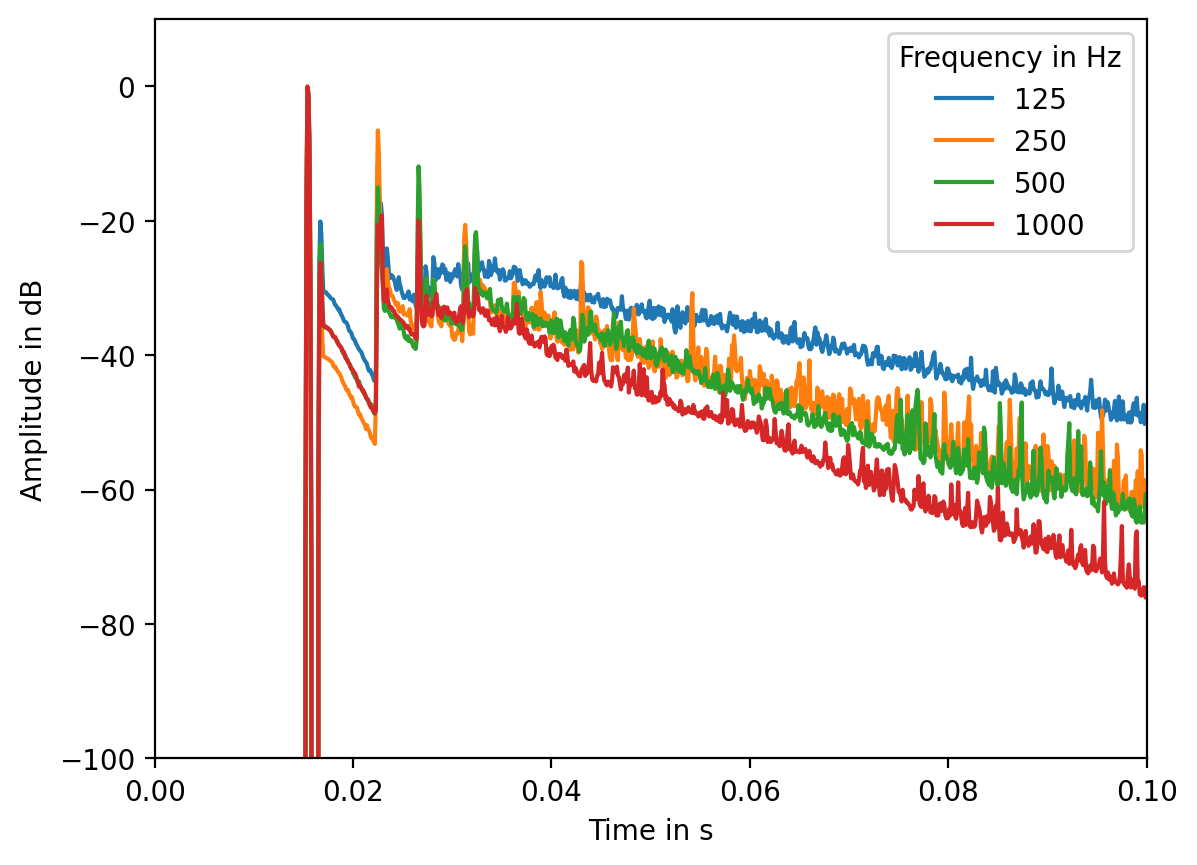

In [40]:
plot_etc(etc, sampling_rate, max_time, dB=True, normalize=True)
plt.legend(frequencies, title='Frequency in Hz')  # add legend with frequency bins
plt.show()